## Import Libraries


### CUDA


In [11]:
!nvidia-smi

Sat Dec  9 20:09:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   33C    P8    18W / 160W |    347MiB /  6144MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import another Libraries

In [1]:
import numpy as np
import seaborn as sns
import pickle
import missingno as msno
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV


### Converting data types

In [134]:
df_prepared = pd.read_csv('../data/df_prepared.csv')
print(df_prepared.shape)
df_prepared.head(5)

(1897005, 18)


,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,event_action
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1.0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,360x720,Chrome,Russia,other,0
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1.0,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,other,mobile,Android,Samsung,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1.0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,360x720,Chrome,Russia,other,0
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1.0,kjsLglQLzykiRbcDiGcD,cpc,other,other,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2.0,kjsLglQLzykiRbcDiGcD,cpc,other,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,0


In [135]:
df_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1897005 entries, 0 to 1912569
Data columns (total 18 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   session_id                object 
 1   client_id                 object 
 2   visit_date                object 
 3   visit_time                object 
 4   visit_number              float64
 5   utm_source                object 
 6   utm_medium                object 
 7   utm_campaign              object 
 8   utm_adcontent             object 
 9   utm_keyword               object 
 10  device_category           object 
 11  device_os                 object 
 12  device_brand              object 
 13  device_screen_resolution  object 
 14  device_browser            object 
 15  geo_country               object 
 16  geo_city                  object 
 17  event_action              int64  
dtypes: float64(1), int64(1), object(16)
memory usage: 275.0+ MB


In [136]:
df_prepared.visit_date = pd.to_datetime(df_prepared.visit_date, utc=True)
df_prepared.visit_time = pd.to_datetime(df_prepared.visit_time, utc=True)

/tmp/ipykernel_2537/3789429630.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_prepared.visit_time = pd.to_datetime(df_prepared.visit_time, utc=True)


In [137]:
df_prepared.visit_number.value_counts()

visit_number
1.0      1398641
2.0       241388
3.0        83499
4.0        43320
5.0        25204
          ...   
446.0          1
447.0          1
448.0          1
449.0          1
564.0          1
Name: count, Length: 537, dtype: int64

In [138]:
df_prepared.visit_number = df_prepared.visit_number.astype("float32")
df_prepared.event_action = df_prepared.event_action.astype("int32")

In [139]:
df_prepared.columns.unique()

Index(['session_id', 'client_id', 'visit_date', 'visit_time', 'visit_number',
       'utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'utm_keyword', 'device_category', 'device_os', 'device_brand',
       'device_screen_resolution', 'device_browser', 'geo_country', 'geo_city',
       'event_action'],
      dtype='object')

In [140]:
columns_for_category = ['session_id', 'client_id', 'utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'utm_keyword', 'device_category', 'device_os', 'device_brand',
       'device_screen_resolution', 'device_browser', 'geo_country', 'geo_city']

In [141]:
df_prepared[columns_for_category] = df_prepared[columns_for_category].astype("category")

In [142]:
df_prepared.describe().round(2)

,visit_number,event_action
count,1897005.00,1897005.00
mean,2.83,0.05
std,13.40,0.21
min,1.00,0.00
25%,1.00,0.00
50%,1.00,0.00
75%,2.00,0.00
max,564.00,1.00


In [143]:
df_for_feature = df_prepared.copy()

###  Feature engineering

In [144]:
# df_for_feature = pd.read_csv('../data/df_for_feature.csv')
print(df_for_feature.shape)
df_for_feature.head(5)

(1897005, 18)


,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,event_action
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24 00:00:00+00:00,2023-12-09 14:36:32+00:00,1.0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,360x720,Chrome,Russia,other,0
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14 00:00:00+00:00,2023-12-09 08:21:30+00:00,1.0,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,other,mobile,Android,Samsung,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28 00:00:00+00:00,2023-12-09 02:42:06+00:00,1.0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,360x720,Chrome,Russia,other,0
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29 00:00:00+00:00,2023-12-09 05:00:00+00:00,1.0,kjsLglQLzykiRbcDiGcD,cpc,other,other,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29 00:00:00+00:00,2023-12-09 05:00:00+00:00,2.0,kjsLglQLzykiRbcDiGcD,cpc,other,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,0


In [145]:
df_for_feature['visit_year'] = df_for_feature.visit_date.dt.year.astype('int32')
df_for_feature['visit_month'] = df_for_feature.visit_date.dt.month.astype('int32')
df_for_feature['visit_day'] = df_for_feature.visit_date.dt.day.astype('int32')


In [146]:
df_for_feature.drop('visit_date',axis=1, inplace=True)

In [147]:
df_for_feature['visit_hour'] = df_for_feature.visit_time.dt.hour.astype('int32')
df_for_feature['visit_minute'] = df_for_feature.visit_time.dt.minute.astype('int32')


In [148]:
df_for_feature.drop('visit_time',axis=1, inplace=True)

In [149]:
df_for_feature.drop('session_id',axis=1, inplace=True)

In [150]:
df_for_feature.device_screen_resolution.value_counts()

device_screen_resolution
414x896      172471
1920x1080    128129
375x812      120540
393x851      117561
375x667       95227
              ...  
360x941           1
360x942           1
360x945           1
360x946           1
999x699           1
Name: count, Length: 5039, dtype: int64

In [151]:
df_for_feature['device_screen_width'] = df_for_feature.device_screen_resolution.apply(lambda x: x.split('x')[0])

In [152]:
df_for_feature['device_screen_heiht'] = df_for_feature.device_screen_resolution.apply(lambda x: x.split('x')[-1])

In [153]:
df_for_feature.drop('device_screen_resolution',axis=1, inplace=True)

### OneHotEncoder

In [154]:
# df_prepared = pd.read_csv('../tmp_data/df_for_feature.csv')
# df_prepared.head()

df_for_feature.head()

,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,...,geo_country,geo_city,event_action,visit_year,visit_month,visit_day,visit_hour,visit_minute,device_screen_width,device_screen_heiht
0,2108382700.163776,1.0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,...,Russia,other,0,2021,11,24,14,36,360,720
1,210838531.163687,1.0,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,other,mobile,Android,Samsung,...,Russia,Moscow,0,2021,11,14,8,21,385,854
2,2108385331.164065,1.0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,...,Russia,other,0,2021,12,28,2,42,360,720
3,2108385564.162225,1.0,kjsLglQLzykiRbcDiGcD,cpc,other,other,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,...,Russia,Moscow,0,2021,5,29,5,0,393,786
4,2108385564.162225,2.0,kjsLglQLzykiRbcDiGcD,cpc,other,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,...,Russia,Moscow,0,2021,5,29,5,0,393,786


In [155]:
df_for_feature.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1897005 entries, 0 to 1912569
Data columns (total 21 columns):
 #   Column               Dtype   
---  ------               -----   
 0   client_id            category
 1   visit_number         float32 
 2   utm_source           category
 3   utm_medium           category
 4   utm_campaign         category
 5   utm_adcontent        category
 6   utm_keyword          category
 7   device_category      category
 8   device_os            category
 9   device_brand         category
 10  device_browser       category
 11  geo_country          category
 12  geo_city             category
 13  event_action         int32   
 14  visit_year           int32   
 15  visit_month          int32   
 16  visit_day            int32   
 17  visit_hour           int32   
 18  visit_minute         int32   
 19  device_screen_width  object  
 20  device_screen_heiht  object  
dtypes: category(12), float32(1), int32(6), object(2)
memory usage: 164.1+ MB


In [156]:
df_for_feature.device_screen_width = df_for_feature.device_screen_width.replace('(not set)', 0)
df_for_feature.device_screen_heiht = df_for_feature.device_screen_heiht.replace('(not set)', 0)

df_for_feature.device_screen_width = df_for_feature.device_screen_width.astype("int32")
df_for_feature.device_screen_heiht = df_for_feature.device_screen_heiht.astype("int32")


In [157]:
ohe_columns = ['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent', 'utm_keyword','device_category', 'device_os', 'device_brand', 'device_browser', 'geo_country', 'geo_city']

In [158]:
data = df_for_feature[ohe_columns]
data

,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_browser,geo_country,geo_city
0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,Chrome,Russia,other
1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,other,mobile,Android,Samsung,Samsung Internet,Russia,Moscow
2,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,Chrome,Russia,other
3,kjsLglQLzykiRbcDiGcD,cpc,other,other,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,Chrome,Russia,Moscow
4,kjsLglQLzykiRbcDiGcD,cpc,other,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,Chrome,Russia,Moscow
...,...,...,...,...,...,...,...,...,...,...,...
1912565,BHcvLfOaCWvWTykYqHVe,cpc,other,JNHcPlZPxEMWDnRiyoBf,other,desktop,Windows,Other,Chrome,Russia,Moscow
1912566,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,Safari,Russia,other
1912567,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,Safari,Russia,Moscow
1912568,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,Chrome,Russia,other


In [159]:
ohe = OneHotEncoder(sparse_output=False)
ohe

OneHotEncoder(sparse_output=False)

In [160]:
ohe.fit(data)

OneHotEncoder(sparse_output=False)

In [161]:
df_ohe = ohe.transform(data)

In [162]:
df_ohe.shape

(1897005, 99)

In [163]:
ohe.get_feature_names_out()

array(['utm_source_BHcvLfOaCWvWTykYqHVe',
       'utm_source_ISrKoXQCxqqYvAZICvjs',
       'utm_source_MvfHsxITijuriZxsqZqt',
       'utm_source_PlbkrSYoHuZBWfYjYnfw',
       'utm_source_QxAxdyPLuQMEcrdZWdWb',
       'utm_source_RmEBuqrriAfAVsLQQmhk',
       'utm_source_SzZERoLMmrEUEhDaYcyN',
       'utm_source_ZpYIoDJMcFzVoPFsHGJL',
       'utm_source_aXQzDWsJuGXeBXexNHjc',
       'utm_source_bByPQxmDaMXgpHeypKSM',
       'utm_source_eLzNJHzPelJpEyBwMrKo',
       'utm_source_fDLlAcSmythWSCVMvqvL',
       'utm_source_fgymSoTvjKPEgaIJqsiH',
       'utm_source_gDBGzjFKYabGgSPZvrDH',
       'utm_source_geDcueAOghDzHkGMmdOq',
       'utm_source_hTjLvqNxGggkGnxSCaTm',
       'utm_source_jaSOmLICuBzCFqHfBdRg',
       'utm_source_kjsLglQLzykiRbcDiGcD',
       'utm_source_nSReTmyFtbSjlPrTKoaX', 'utm_source_other',
       'utm_source_vFcAhRxLfOWKhvxjELkx', 'utm_medium_(none)',
       'utm_medium_banner', 'utm_medium_cpc', 'utm_medium_cpm',
       'utm_medium_email', 'utm_medium_organic', 'utm_m

In [164]:
len(ohe.get_feature_names_out())

99

In [165]:
df_for_feature[ohe.get_feature_names_out()] = df_ohe


/tmp/ipykernel_2537/3556889132.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_for_feature[ohe.get_feature_names_out()] = df_ohe
/tmp/ipykernel_2537/3556889132.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_for_feature[ohe.get_feature_names_out()] = df_ohe
/tmp/ipykernel_2537/3556889132.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a

In [166]:
df_for_feature.to_csv('../data/df_for_feature.csv', index=False)

In [167]:
df_for_feature.shape

(1897005, 120)

### Нормализация данных

In [168]:
columns = ['visit_number', 'visit_year', 'visit_month', 'visit_day', 'visit_hour', 'visit_minute', 'device_screen_width', 'device_screen_heiht']

In [169]:
data1 = df_for_feature[columns]
data1.sample(3)

,visit_number,visit_year,visit_month,visit_day,visit_hour,visit_minute,device_screen_width,device_screen_heiht
1454896,5.0,2021,11,19,20,0,360,640
395876,1.0,2021,7,14,18,0,412,869
1461263,3.0,2021,12,1,6,9,393,851


In [170]:
#Создаем объект std_scaler класса StandardScaler с параметрами по умолчанию,
std_scaler = StandardScaler()
std_scaler

StandardScaler()

In [171]:
std_scaler.fit(data1)

std_scaled_transform = std_scaler.transform(data1)

df_for_feature[['visit_number_std', 'visit_year_std', 'visit_month_std', 'visit_day_std', 'visit_hour_std', 'visit_minute_std', 'device_screen_width_std', 'device_screen_heiht_std']] = std_scaled_transform

/tmp/ipykernel_2537/3635722671.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_for_feature[['visit_number_std', 'visit_year_std', 'visit_month_std', 'visit_day_std', 'visit_hour_std', 'visit_minute_std', 'device_screen_width_std', 'device_screen_heiht_std']] = std_scaled_transform
/tmp/ipykernel_2537/3635722671.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_for_feature[['visit_number_std', 'visit_year_std', 'visit_month_std', 'visit_day_std', 'visit_hour_std', 'visit_minute_std', 'device_screen_width_std', 'device

In [172]:
columns_for_drop = ohe_columns + columns
columns_for_drop


['utm_source',
 'utm_medium',
 'utm_campaign',
 'utm_adcontent',
 'utm_keyword',
 'device_category',
 'device_os',
 'device_brand',
 'device_browser',
 'geo_country',
 'geo_city',
 'visit_number',
 'visit_year',
 'visit_month',
 'visit_day',
 'visit_hour',
 'visit_minute',
 'device_screen_width',
 'device_screen_heiht']

In [173]:
df_for_modeling = df_for_feature.drop(columns_for_drop, axis=1)
df_for_modeling.shape

(1897005, 109)

In [174]:
df_for_modeling.to_csv('../data/df_for_modeling.csv', index=False)

## Modeling

In [2]:
df_for_modeling = pd.read_csv('../data/df_for_modeling.csv')
df_for_modeling.head()

,client_id,event_action,utm_source_BHcvLfOaCWvWTykYqHVe,utm_source_ISrKoXQCxqqYvAZICvjs,utm_source_MvfHsxITijuriZxsqZqt,utm_source_PlbkrSYoHuZBWfYjYnfw,utm_source_QxAxdyPLuQMEcrdZWdWb,utm_source_RmEBuqrriAfAVsLQQmhk,utm_source_SzZERoLMmrEUEhDaYcyN,utm_source_ZpYIoDJMcFzVoPFsHGJL,...,geo_city_Yekaterinburg,geo_city_other,visit_number_std,visit_year_std,visit_month_std,visit_day_std,visit_hour_std,visit_minute_std,device_screen_width_std,device_screen_heiht_std
0,2108382700.163776,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,-0.135647,0.0,0.763072,0.801672,0.062317,1.275754,-0.536724,-0.627232
1,210838531.163687,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.135647,0.0,0.763072,-0.335917,-0.919135,0.461451,-0.491522,0.067072
2,2108385331.164065,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,-0.135647,0.0,1.217193,1.256708,-1.900587,1.601475,-0.536724,-0.627232
3,2108385564.162225,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.135647,0.0,-1.961653,1.370467,-1.409861,-0.678573,-0.477057,-0.285261
4,2108385564.162225,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.061331,0.0,-1.961653,1.370467,-1.409861,-0.678573,-0.477057,-0.285261


In [3]:
df_for_modeling.shape

(1897005, 109)

In [4]:
# drop non information column
df_for_modeling = df_for_modeling.drop(['client_id'], axis=1)

# save variables
x = df_for_modeling.drop(['event_action'], axis=1)
y = df_for_modeling['event_action']

In [5]:
 # Separate data on train & test;
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

### LogisticRegression

In [19]:
lg = LogisticRegression(random_state=42, max_iter=10000)

In [20]:
# Learn model on default params
lg.fit(x_train, y_train) # LogisticRegression

LogisticRegression(max_iter=10000, random_state=42)

In [21]:
# Get predict
lr_probs = lg.predict_proba(x_test)

In [22]:
# save probabilities only for a positive outcome
lr_probs = lr_probs[:, 1]

In [23]:
# calculate the ROC AUC
lr_auc = roc_auc_score(y_test, lr_probs)
print('LogisticRegression: ROC AUC=%.3f' % (lr_auc))

LogisticRegression: ROC AUC=0.682


In [25]:
# calculating the roc curve
fpr, tpr, treshold = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)

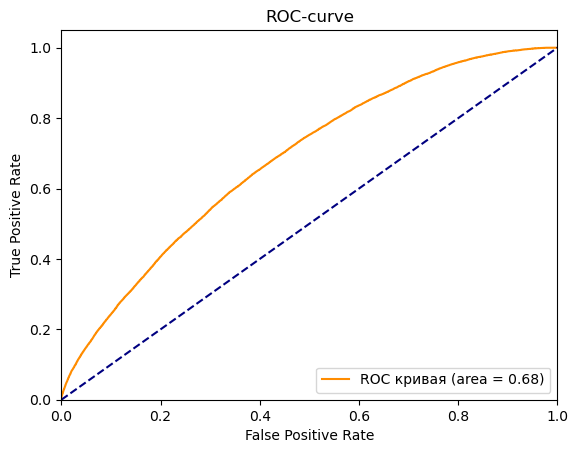

In [26]:
# plotting a graph
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.legend(loc="lower right")
plt.show()

#### Cross-Validate


In [27]:
cross_validate(lg, x, y, scoring='roc_auc', cv=5)

{'fit_time': array([ 63.33345842, 114.01772165,  97.31402016,  72.04445052,
         73.34605074]),
 'score_time': array([0.10317039, 0.1034956 , 0.10265899, 0.10452628, 0.1032927 ]),
 'test_score': array([0.67988703, 0.67740791, 0.67563121, 0.67336608, 0.68395605])}

In [28]:
cv_score_lg = cross_val_score(lg, x, y, scoring='roc_auc', cv=5)
cv_score_lg

array([0.67988703, 0.67740791, 0.67563121, 0.67336608, 0.68395605])

In [29]:
cv_score_lg.mean(), cv_score_lg.std()

(0.6780496563100845, 0.0036457667758624983)

### Random Forest


In [30]:
rf = RandomForestClassifier(random_state=42)

In [31]:
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [32]:
# Get predict
rf_probs = rf.predict_proba(x_test)

In [33]:
# save probabilities only for a positive outcome
rf_probs = rf_probs[:, 1]

In [34]:
# calculate the ROC AUC
rf_auc = roc_auc_score(y_test, rf_probs)
print('RandomFores: ROC AUC=%.3f' % (rf_auc))

RandomFores: ROC AUC=0.837


In [35]:
# calculating the roc curve
fpr, tpr, treshold = roc_curve(y_test, rf_probs)
roc_auc = auc(fpr, tpr)

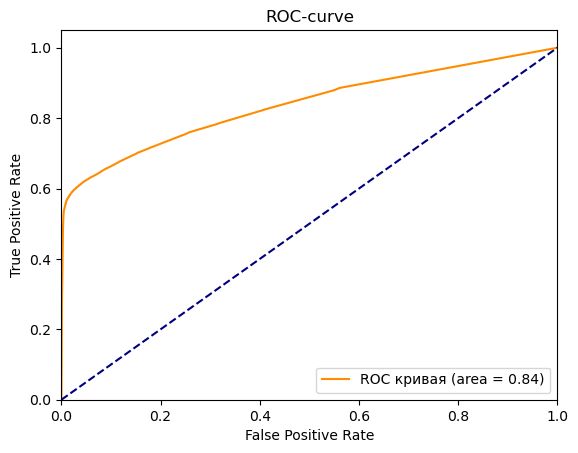

In [36]:
# plotting a graph
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.legend(loc="lower right")
plt.show()

#### Cross Validate

In [37]:
cross_validate(rf, x, y, scoring='roc_auc', cv=5)

{'fit_time': array([220.23054004, 221.76332641, 222.06965232, 223.6226964 ,
        217.32353497]),
 'score_time': array([13.02737856, 13.66488552, 12.97493982, 13.04960299, 13.03740144]),
 'test_score': array([0.62346093, 0.61960374, 0.6230728 , 0.61935216, 0.63866474])}

In [38]:
cv_score_rf = cross_val_score(rf, x, y, scoring='roc_auc', cv=5)
cv_score_rf

array([0.62346093, 0.61960374, 0.6230728 , 0.61935216, 0.63866474])

In [39]:
cv_score_rf.mean(), cv_score_rf.std()

(0.6248308713800391, 0.00712295661512224)

### MLP

In [40]:
mlp = MLPClassifier(random_state=42, max_iter=1000)
mlp.fit(x_train, y_train)

MLPClassifier(max_iter=1000, random_state=42)

In [41]:
# Get predict
mlp_probs = mlp.predict_proba(x_test)

In [42]:
# save probabilities only for a positive outcome
mlp_probs = mlp_probs[:, 1]

In [43]:
# calculate the ROC AUC
mlp_auc = roc_auc_score(y_test, mlp_probs)
print('RandomFores: ROC AUC=%.3f' % (mlp_auc))

RandomFores: ROC AUC=0.724


In [44]:
# calculating the roc curve
fpr, tpr, treshold = roc_curve(y_test, mlp_probs)
roc_auc = auc(fpr, tpr)

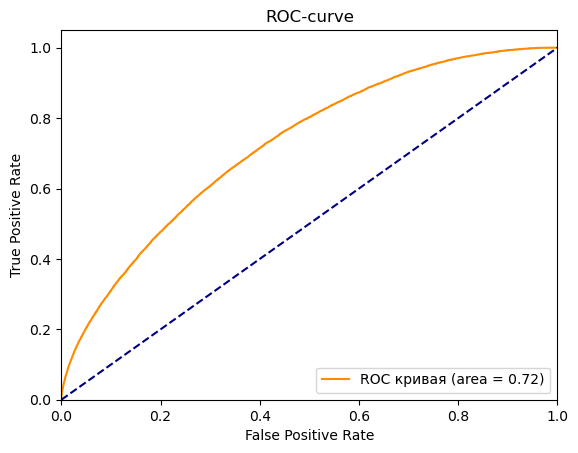

In [45]:
# plotting a graph
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.legend(loc="lower right")
plt.show()

#### Cross Validate

In [229]:
cross_validate(mlp, x, y, scoring='roc_auc', cv=5)

{'fit_time': array([242.10930014, 236.440799  , 201.8130877 , 185.014467  ,
        216.35820556]),
 'score_time': array([0.70252538, 0.50874639, 0.66520262, 0.57912564, 0.54700375]),
 'test_score': array([0.69730451, 0.69949613, 0.69758263, 0.6996512 , 0.67794978])}

In [46]:
cv_score_mlp = cross_val_score(mlp, x, y, scoring='roc_auc', cv=5)
cv_score_mlp

array([0.69730451, 0.69949613, 0.69758263, 0.6996512 , 0.67794978])

In [47]:
cv_score_mlp.mean(), cv_score_mlp.std()

(0.6943968494589547, 0.00827913601553589)

### SGDClassifier 

In [48]:
from sklearn.linear_model import SGDClassifier 

In [49]:
sgd = SGDClassifier(loss="log_loss")
sgd.fit(x_train, y_train)

SGDClassifier(loss='log_loss')

In [50]:
# Get predict
sgd_probs = sgd.predict_proba(x_test)

In [51]:
# save probabilities only for a positive outcome
sgd_probs = sgd_probs[:, 1]

In [52]:
# calculate the ROC AUC
sgd_auc = roc_auc_score(y_test, sgd_probs)
print('SVM: ROC AUC=%.3f' % (sgd_auc))

SVM: ROC AUC=0.680


In [53]:
# calculating the roc curve
fpr, tpr, treshold = roc_curve(y_test, sgd_probs)
roc_auc = auc(fpr, tpr)

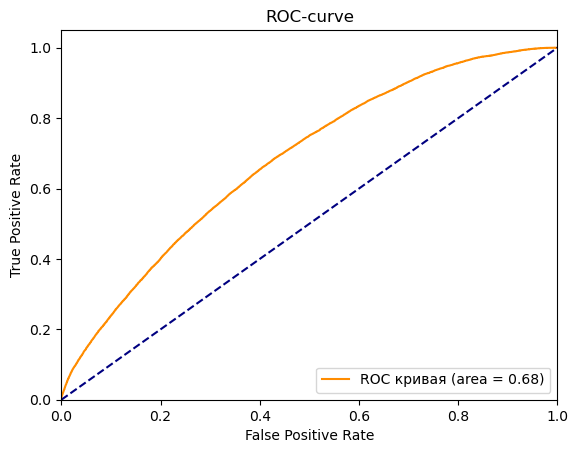

In [54]:
# plotting a graph
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.legend(loc="lower right")
plt.show()

#### Cross Validate

In [15]:
cross_validate(sgd, x, y, scoring='roc_auc', cv=5)

{'fit_time': array([7.14254904, 6.56075978, 6.55378246, 7.09118009, 6.57847118]),
 'score_time': array([0.10335612, 0.10372138, 0.10328579, 0.10279298, 0.10411167]),
 'test_score': array([0.65789502, 0.64923376, 0.64569455, 0.63952122, 0.66785844])}

In [55]:
cv_score_sgd = cross_val_score(sgd, x, y, scoring='roc_auc', cv=5)
cv_score_sgd

array([0.67827884, 0.67548916, 0.67319722, 0.67215652, 0.68060396])

In [56]:
cv_score_sgd.mean(), cv_score_sgd.std()

(0.6759451414550426, 0.0031388960261857068)

### KNeighborsClassifier

In [71]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors = 10)
neigh.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [74]:
# Get predict
neigh_probs = neigh.predict_proba(x_test.values)

AttributeError: 'Flags' object has no attribute 'c_contiguous'

In [61]:
# save probabilities only for a positive outcome
neigh_probs = neigh_probs[:, 1]

In [62]:
# calculate the ROC AUC
neigh_auc = roc_auc_score(y_test, neigh_probs)
print('KNeighborsClassifier: ROC AUC=%.3f' % (neigh_auc))

KNeighborsClassifier: ROC AUC=0.768


#### Cross Validate

In [70]:
cv_score_knn = cross_val_score(neigh, x.values, y, scoring='roc_auc', cv=5)
cv_score_knn

array([0.56353051, 0.5622315 , 0.56272558, 0.56269973, 0.56623652])

In [ ]:
cv_score_sgd.mean(), cv_score_sgd.std()

### Result

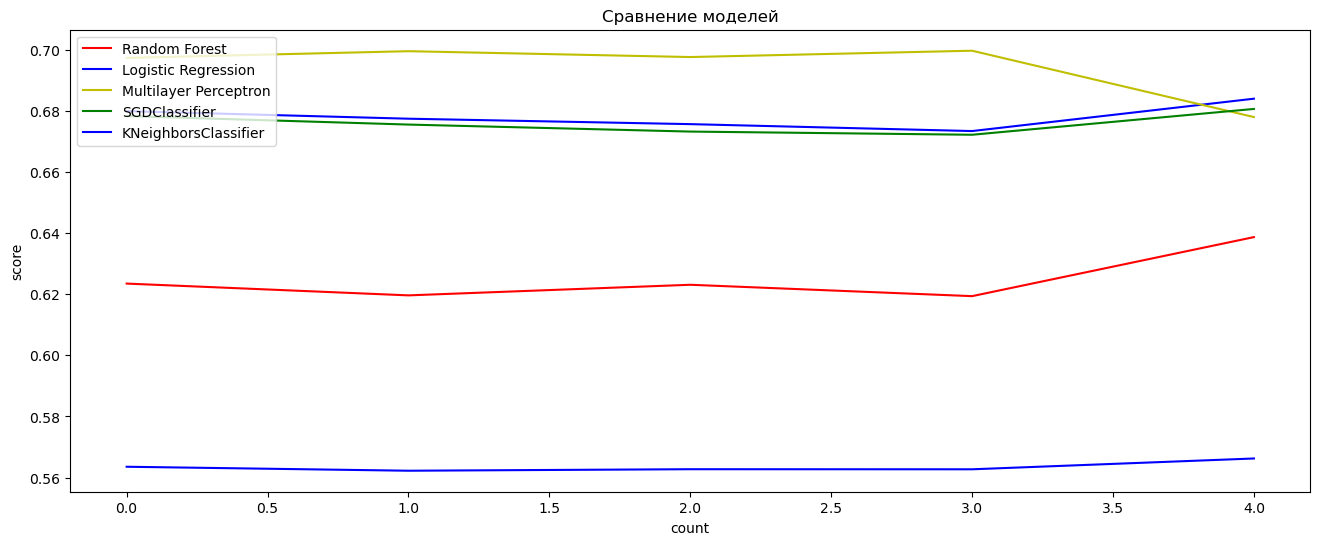

In [72]:
plt.figure(figsize=(16, 6))
plt.plot(cv_score_rf,  label='Random Forest', c = 'r')
plt.plot(cv_score_lg,  label='Logistic Regression', c = 'b')
plt.plot(cv_score_mlp,  label='Multilayer Perceptron',  c = 'y')
plt.plot(cv_score_sgd,  label='SGDClassifier',  c = 'g')
plt.plot(cv_score_knn,  label='KNeighborsClassifier',  c = 'b')
plt.title('Сравнение моделей')
plt.xlabel('count')
plt.ylabel('score')
plt.legend(loc='upper left')
plt.show()

In [235]:
# Обучаем модель на всём датасете;
mlp.fit(x, y)

MLPClassifier(max_iter=1000, random_state=42)